<a href="https://colab.research.google.com/github/chrysshawk/courses/blob/master/W6_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Classification with Python

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
#!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
link = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv'

### Load Data From CSV File  

In [3]:
#df = pd.read_csv('loan_train.csv')
df = pd.read_csv(link)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

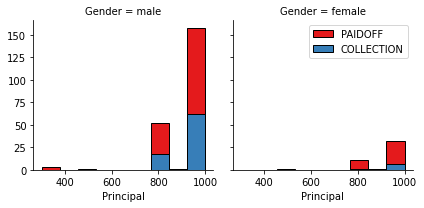

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

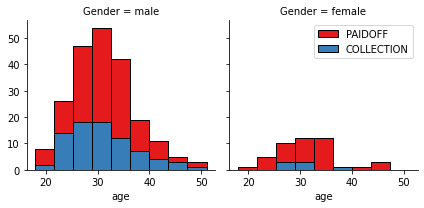

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

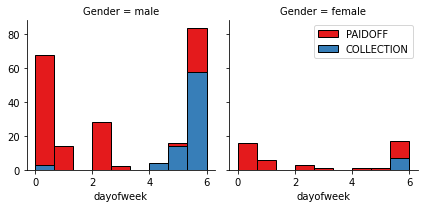

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
# Import required modules from sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [21]:
# Step 1: Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


In [22]:
# Step 2: Run model and evaluate best K

# Initializing with 20 Ks
Ks = 20

# create arrays to store the results of each K
mean_acc = np.zeros((Ks-1)) # Jaccard similarity score
std_acc = np.zeros((Ks-1)) # Standard deviation

for n in range(1,Ks):
    #Train model on train set  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    #Predict model on test set
    yhat=neigh.predict(X_test)
    # Calculate Jaccard similarity score
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    # Calculate std
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print('K={} (neighbors) gives the best test set classification result.'.format(mean_acc.argmax()+1))
print('Its Jaccard similarity score is {}.'.format(mean_acc.max()))

K=7 (neighbors) gives the best test set classification result.
Its Jaccard similarity score is 0.7857142857142857.


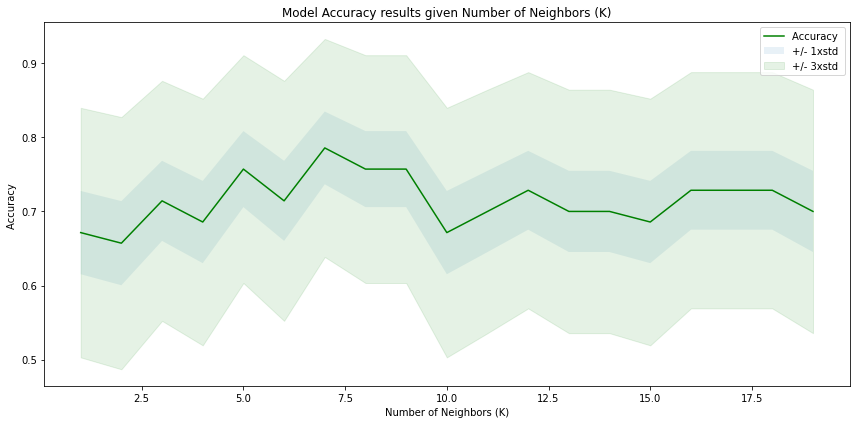

In [23]:
# Step 3: Plot results of different number of K

plt.figure(figsize=(12,6))

# First plot the mean accuracy per K
plt.plot(range(1,Ks),mean_acc,'g')

# Add the fill for +/- 1 std, and for +/- 3 std
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")

plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.title('Model Accuracy results given Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [24]:
# Step 4: Fit model with best K on entire dataset
neigh = KNeighborsClassifier(n_neighbors = mean_acc.argmax()+1).fit(X, y)

# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Step 1: Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

# Step 2: Create and fit model
loanTree = DecisionTreeClassifier(criterion='entropy', max_depth = 4)
loanTree.fit(X_train, y_train)

# Step 3: Create predictions based on test data
yhatTree = loanTree.predict(X_test)

# Step 4: Evaluate model predictions
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, yhatTree))

DecisionTrees's Accuracy:  0.6142857142857143


In [26]:
# Initializing with 20 levels
Ls = 20

# create arrays to store the results of each level
dt_mean_acc = np.zeros((Ls-1)) # Jaccard similarity score

for n in range(1,Ls):
    #Train model on train set  
    loanTree = DecisionTreeClassifier(criterion='entropy', max_depth = n)
    loanTree.fit(X_train, y_train)
    # Step 3: Create predictions based on test data
    yhatTree = loanTree.predict(X_test)
    # Calculate Jaccard similarity score
    dt_mean_acc[n-1] = metrics.accuracy_score(y_test, yhatTree)

# Print results
print('The optimal number of levels for the decision tree are:', dt_mean_acc.argmax()+1)
print('Its Jaccard similarity score is {} for the test split.'.format(dt_mean_acc.max()))

# Fit model with optimal Level on entire dataset
loanTree = DecisionTreeClassifier(criterion='entropy', max_depth=dt_mean_acc.argmax()+1).fit(X,y)

The optimal number of levels for the decision tree are: 1
Its Jaccard similarity score is 0.7857142857142857 for the test split.


# Support Vector Machine

In [27]:
# Import the SVM model
from sklearn import svm

# Step 1: Create the model, and specify the kernel type
clf = svm.SVC(kernel='rbf')

# Step 2: Train the model
clf.fit(X_train, y_train)

# Step 2: Predict based on test data
clf_yhat = clf.predict(X_test)

print('Jaccard score for SVM model on test data:', metrics.accuracy_score(y_test, clf_yhat))

# Train the model on entire train dataset:
clf = svm.SVC(kernel='rbf').fit(X, y)

Jaccard score for SVM model on test data: 0.7428571428571429


# Logistic Regression

In [28]:
# Import model library
from sklearn.linear_model import LogisticRegression

# Step 1: Create and fit model, defining regularization strength C (smaller=stronger)
loanLR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

# Step 2: Predict on test set, include probabilities
LR_yhat = loanLR.predict(X_test)
LR_yhat_prob = loanLR.predict_proba(X_test)

print('Jaccard score for Logistic Regression on test dataset:', 
      metrics.accuracy_score(y_test, LR_yhat))

# Step 3: Train the model on entire train dataset
loanLR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)

Jaccard score for Logistic Regression on test dataset: 0.6857142857142857


# Model Evaluation using Test set

In [29]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [30]:
#!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
link_test = 'https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv'

### Load Test set for evaluation 

In [31]:
#test_df = pd.read_csv('loan_test.csv')
test_df = pd.read_csv(link_test)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [32]:
# Step 1: Prepare the test dataframe in same manner as the train dataframe
# to ensure consistency of data

# Convert to datetime
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

# Determine day of week and weekend
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

# Change male/female to 0/1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

# Extract features, convert education to dummies
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)
test_X = test_Feature

# Assign dependent variable
test_y = test_df['loan_status'].values

#Normalize the features
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X)

#Define prediction variable labels
yhat_labels = ['COLLECTION', 'PAIDOFF']

In [33]:
# Compute KNN scores
knn_yhat = neigh.predict(test_X)
knn_jaccard = metrics.accuracy_score(test_y, knn_yhat)
knn_f1 = metrics.f1_score(test_y, knn_yhat, labels=yhat_labels, average='weighted')
print('KNN Jaccard Score:', knn_jaccard)
print('KNN F1 Score:', knn_f1)

KNN Jaccard Score: 0.7222222222222222
KNN F1 Score: 0.7001989201477693


In [34]:
# Compute DecisionTree scores
dt_yhat = loanTree.predict(test_X)
dt_jaccard = metrics.accuracy_score(test_y, dt_yhat)
dt_f1 = metrics.f1_score(test_y, dt_yhat, labels=yhat_labels, average='weighted')
print('DecisionTree Jaccard Score:', dt_jaccard)
print('DecisionTree F1 Score:', dt_f1)

DecisionTree Jaccard Score: 0.7407407407407407
DecisionTree F1 Score: 0.6304176516942475


In [35]:
# Compute SVM scores
svm_yhat = clf.predict(test_X)
svm_jaccard = metrics.accuracy_score(test_y, svm_yhat)
svm_f1 = metrics.f1_score(test_y, svm_yhat, labels=yhat_labels, average='weighted')
print('SVM Jaccard Score:', svm_jaccard)
print('SVM F1 Score:', svm_f1)

SVM Jaccard Score: 0.7222222222222222
SVM F1 Score: 0.6212664277180406


In [36]:
# Compute Logistic Regression scores
from sklearn.metrics import log_loss

# Make predictions
LR_yhat = loanLR.predict(test_X)
LR_yhat_prob = loanLR.predict_proba(test_X)

# Calculate scores
LR_jaccard = metrics.accuracy_score(test_y, LR_yhat)
LR_f1 = metrics.f1_score(test_y, LR_yhat, labels=yhat_labels, average='weighted')
LR_logloss = log_loss(test_y, LR_yhat_prob)

print('Logistic Regression Jaccard Score:', LR_jaccard)
print('Logistic Regression F1 Score:', LR_f1)
print('Logistic Regression Log Loss:', LR_logloss)

Logistic Regression Jaccard Score: 0.7407407407407407
Logistic Regression F1 Score: 0.6304176516942475
Logistic Regression Log Loss: 0.5566084946309205


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [37]:
# Make report
cols = ['Algorithm', 'Jaccard', 'F1-score', 'LogLoss']
report_df = pd.DataFrame([['KNN', knn_jaccard, knn_f1, 'NA'],
                          ['DecisionTree', dt_jaccard, dt_f1, 'NA'],
                          ['SVM', svm_jaccard, svm_f1, 'NA'],
                          ['LogisticRegression', LR_jaccard, LR_f1, LR_logloss]],
                         columns=cols)
report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.722222,0.700199,NA
1,DecisionTree,0.740741,0.630418,NA
2,SVM,0.722222,0.621266,NA
3,LogisticRegression,0.740741,0.630418,0.556608


Overall, we can observe the Decision Tree and Logistic Regression methods have the highest Jaccard scores; but we might want to use the latter if we were interested in the probabilities associated with each outcome.

Judging by the F1-scores, the KNN model works the best.

However, the above result is affected by model tuning; i.e. by improving the tunings and setup of the above models, they might improve their scores.